In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Compute Fst values with *PLINK*

In [2]:
import re
import pandas as pd

from os.path import expanduser, join, isfile
from components.dataset import Dataset
from components.panel import Panel
from subprocess import call


WORKDIR = expanduser("~/tesina/1000Genomes/fst_analysis")
# Put the bedfiles of the panels you want to analyse in the WORKDIR.
# Then run this cell. Ta-dah!
# (The data should come from 1000 Genomes for this to work.)


analysis_files = []
for dataset in Dataset.all_datasets():

    # Write .population.fam, .superpopulation.fam, and .samples files
    dataset.write_clusters_files(WORKDIR)
    dataset.write_samples_file(WORKDIR)

    for panel in Panel.all_panels() + Panel.all_control_panels():
        
        if not isfile(join(WORKDIR, panel.label + ".bed")):
            continue

        # Generate dataset/panel specific bedfiles
        new_bfile = join(WORKDIR, "{}.{}".format(dataset.label, panel.label))
        command = ["plink",
                   "--bfile", join(WORKDIR, panel.label),
                   "--keep-fam", join(WORKDIR, "{}.samples".format(dataset.label)),
                   "--make-bed", "--out", new_bfile]       
        call(command)
        
        # Compute Fst for each dataset/panel/population level combination
        for population_level in ["population", "superpopulation"]:
            
            clusters_file = join(WORKDIR, "{}.{}.clusters".format(dataset.label, population_level))
            level_analysis_file = "{}.{}".format(new_bfile, population_level)
            command = ["plink",
                       "--bfile", new_bfile,
                       "--within", clusters_file, "--fst",
                       "--make-bed", "--out", level_analysis_file]
            call(command)
            
            analysis_files.append(level_analysis_file + ".fst")

# Read the Fst files

In [24]:
def fst_format(x):
    # return x
    return round(x, 4)

frames = []

for filepath in analysis_files:
    dataset_label, panel_label, pop_level = \
        re.search("(\w*)\.(\w*).(\w*).", filepath).groups()

    try:
        fst_df = pd.read_table(filepath)
    except OSError:
        print("[!] No file for {} {} {}".format(dataset_label, panel_label, pop_level))
        continue

    fst_df["panel"] = panel_label
    fst_df["dataset"] = dataset_label
    fst_df["pop_level"] = pop_level
    mean_fst = fst_df["FST"].mean()
    
    # print(dataset_label, panel_label, population_level, mean_fst)
    frames.append(fst_df)
    
fst_df = pd.concat(frames).set_index(["pop_level", "dataset", "panel", "SNP"])

mean_fst = fst_df.groupby(level=["dataset", "panel", "pop_level"]).mean()["FST"]
mean_fst = mean_fst.map(fst_format).to_frame().sort_index()
mean_fst = mean_fst.reset_index().pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
mean_fst

[!] No file for L GAL_Affy superpopulation
[!] No file for L GAL_Completo superpopulation
[!] No file for L GAL_Faltantes superpopulation
[!] No file for L CPx1 superpopulation
[!] No file for L CPx10 superpopulation
[!] No file for L CPx100 superpopulation


panel                      CPx1   CPx10  CPx100  GAL_Affy  GAL_Completo  \
pop_level       dataset                                                   
population      L        0.0183  0.0188  0.0189    0.0991        0.1044   
                LE       0.0219  0.0226  0.0224    0.1268        0.1365   
                LEA      0.0623  0.0603  0.0598    0.3646        0.3330   
                LEAC     0.0741  0.0707  0.0697    0.3370        0.3092   
                LEACI    0.0716  0.0687  0.0676    0.3183        0.2905   
superpopulation LE       0.0180  0.0189  0.0184    0.1102        0.1214   
                LEA      0.0689  0.0665  0.0658    0.3863        0.3488   
                LEAC     0.0797  0.0755  0.0744    0.3474        0.3153   
                LEACI    0.0748  0.0713  0.0701    0.3221        0.2905   

panel                    GAL_Faltantes  
pop_level       dataset                 
population      L               0.1087  
                LE              0.1440  
                LEA             0.3104  
                LEAC            0.2894  
                LEACI           0.2706  
superpopulation LE              0.1299  
                LEA             0.3216  
                LEAC            0.2922  
                LEACI           0.2676

# Plot a heatmap of the mean Fst per dataset/panel/pop_level

Fst promedio por población
/home/juan/tesina/charts/panel_analyses/fst_heatmap__per_population


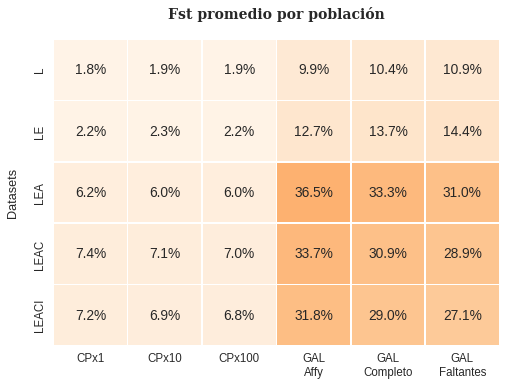

Fst promedio por población
/home/juan/tesina/charts/panel_analyses/fst_barchart__per_population


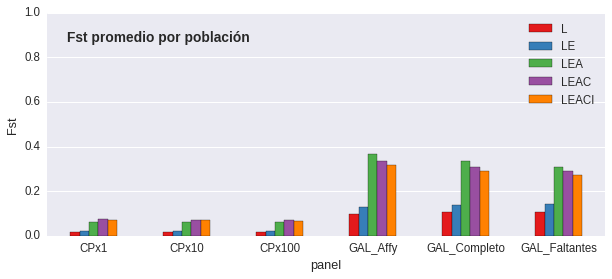

Fst promedio por continente
/home/juan/tesina/charts/panel_analyses/fst_heatmap__per_superpopulation


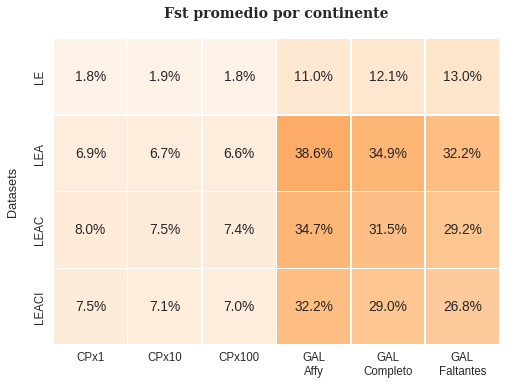

Fst promedio por continente
/home/juan/tesina/charts/panel_analyses/fst_barchart__per_superpopulation


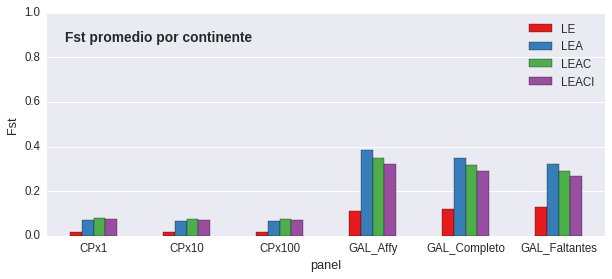

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import expanduser, join


fdir = expanduser("~/tesina/charts/panel_analyses")

sns.set_context("paper", font_scale=1.5)
sns.set_style("white")

trans = {"population": "población", "superpopulation": "continente"}

for level in mean_fst.index.get_level_values("pop_level").unique():
    df = mean_fst.loc[level]
    columnns = [col for col in df.columns if "Faltantes" not in col]
    df = df[columnns]
    
    fig = plt.figure()
    palette = sns.color_palette("Blues")

    ax = sns.heatmap(df, annot=True, linewidths=.5, fmt=".1%",
                     vmax=1, vmin=0, cmap="Oranges", cbar=False)
    
    fig = ax.get_figure()
    ax.set_ylabel("Datasets", labelpad=15)
    ax.set_xlabel("")
    xticklabels = ["\n".join(s.get_text().split("_")) for s in ax.get_xticklabels()]
    _ = ax.set_xticklabels(xticklabels,
                           rotation=0)
    caption = "Fst promedio por {}".format(trans[level])
    filepath = join(fdir, "fst_heatmap__per_{}".format(level))
    plt.savefig(filepath, bbox_inches="tight")
    print(caption)
    print(filepath)
    plt.show()    
    
    color = sns.color_palette("Set1", 5)
    ax = df.T.plot(kind="bar", figsize=(10, 2.5), rot=0, color=color)    
    ax.set_ylabel("Fst")
    ax.legend(fancybox=True, loc="best", bbox_to_anchor=(1.01, .75))
    ax.set_ylim([0, .5])
    ax.set_yticks([0, .5])
    sns.despine(left=True)
    ax.yaxis.grid()
    caption = "Fst promedio por {}".format(trans[level])
    filepath = join(fdir, "fst_barchart__per_{}".format(level))
    plt.savefig(filepath, bbox_inches="tight")
    print(caption)
    print(filepath)
    plt.show()

# Safety check between my means and Plink ones in the .log files

In [5]:
%%bash

grep Mean ~/tesina/1000Genomes/fst_analysis/*.log | \
ruby -F: -lane 'puts [$F[0].gsub("/home/juan/tesina/1000Genomes/fst_analysis/", "").gsub(".", "\t"), $F.last].join("\t")' \
> ~/tesina/1000Genomes/fst_analysis/plink_fst_means

In [6]:
columns = ["dataset", "panel", "pop_level", "dropme", "FST"]
plink_fst_means = pd.read_table(join(WORKDIR, "plink_fst_means"), header=None, names=columns)
plink_fst_means.drop("dropme", inplace=True, axis=1)
plink_fst_means["FST"] = plink_fst_means["FST"].astype(float).map(lambda x: round(x, 2))
plink_fst_means = plink_fst_means.pivot_table(index=["pop_level", "dataset"],
                                              columns="panel", values="FST")
plink_fst_means - mean_fst

NameError: name 'means' is not defined